In [78]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment by creating mini batches etc.
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay


import sys


import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

In [68]:
#read the data 
#algorithm to read all the files

'''
for folder in this folder:
    read xelasensor1.csv
    read sliplabel.csv
    concat it in a single dataframe along axis = 0

print the dataframe
'''

directory = 'train2dof'
directory2 = '.'

def read_file(detect_or_pred, n = None):

    #store all directories in a list
    list_xela_allfiles = []
    list_sliplabel_allfiles = []

    for root, subdirectories, files in os.walk(directory):
        for sdirectory in subdirectories:

            #subdirectory with absolute path
            subdirectory = '{}/{}'.format(root, sdirectory)

            #read specific files in the subdirectory
            for file in os.listdir(subdirectory):
            
                if file.endswith("sensor1.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    
                    if detect_or_pred ==0:
                        list_xela_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None:
                        list_xela_allfiles.append(df[:-n])

                if file.endswith("label.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    if detect_or_pred ==0:
                        list_sliplabel_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None: 
                        list_sliplabel_allfiles.append(df[n:])

    return list_xela_allfiles, list_sliplabel_allfiles

    #np.newaxis; np.zeros (3,4,4) -> 
                    


In [85]:
#concat the list of xela_allfiles and sliplabel_allfiles across axis = 0
n = 5
list_xela_allfiles, list_sliplabel_allfiles = read_file(0)

#for slip prediction, comment the line above and uncomment the line below
#list_xela_allfiles, list_sliplabel_allfiles = read_file(1, n)

pd_xela_allfiles = pd.concat(list_xela_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd.concat(list_sliplabel_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd_sliplabel_allfiles['slip']

#reshape the target array into (rows, 1)
tac_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)


# RE-ARRANGEMENT OF TABULAR DATA INTO IMAGES

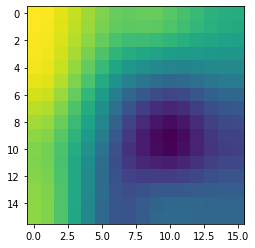

In [86]:
# FOR RESNET arrange the columns by x, y, z
col_x = []
col_y = []
col_z = []

pd_columns = pd_xela_allfiles.columns
for col in pd_columns:
    if col.endswith('x'):
        col_x.append(col)
    
    elif col.endswith('y'):
        col_y.append(col)
    
    elif col.endswith('z'):
        col_z.append(col)

#arrange the table using the arranged columns
pd_xela_allfiles_x = pd_xela_allfiles[col_x]
pd_xela_allfiles_y = pd_xela_allfiles[col_y]
pd_xela_allfiles_z = pd_xela_allfiles[col_z]


#scale the data in the arranged columns
#scale the data of the features

sc = MinMaxScaler() #standard scaler
sc.fit(pd_xela_allfiles_x)
pd_xela_allfiles_x = sc.transform(pd_xela_allfiles_x)

sc.fit(pd_xela_allfiles_y)
pd_xela_allfiles_y = sc.transform(pd_xela_allfiles_y)

sc.fit(pd_xela_allfiles_z)
pd_xela_allfiles_z = sc.transform(pd_xela_allfiles_z)

#reshape the arranged data per row to (4,4) AND rotate 90 degree anti-clockwise and append to a list
pd_x = []
pd_y = []
pd_z = []

for row in range(len(pd_xela_allfiles_x)):
    pd_x.append(np.rot90(pd_xela_allfiles_x[row].reshape(4,4)))
    pd_y.append(np.rot90(pd_xela_allfiles_y[row].reshape(4,4)))
    pd_z.append(np.rot90(pd_xela_allfiles_z[row].reshape(4,4)))

#Upscale each (4, 4) of x, y, z to (224, 224)
import cv2
up_size = 16
n_images = len(pd_x)

tac_imagex = np.zeros((n_images, up_size, up_size), np.float32)
tac_imagey = np.zeros((n_images, up_size, up_size), np.float32) 
tac_imagez = np.zeros((n_images, up_size, up_size), np.float32) 
#resize image to 3, up_size, up_size

for row in range(len(pd_x)):
    img_4_4_x = pd_x[row]
    tac_imagex[row] = cv2.resize(img_4_4_x.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)

for row in range(len(pd_y)):
    img_4_4_y = pd_y[row]
    tac_imagey[row] = cv2.resize(img_4_4_y.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)

for row in range(len(pd_z)):
    img_4_4_z = pd_z[row]
    tac_imagez[row] = cv2.resize(img_4_4_z.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)

pd_main = [tac_imagex, tac_imagey, tac_imagez]

#arrange pd_main in a 3, 224, 224 array where its 3(224, 224) of x, y, z values
pd_image = np.zeros( (pd_xela_allfiles.shape[0], 3, up_size, up_size))

#per row, get (224,224) of x, y, z and assign it to pd_image to form the image
for row in range(pd_xela_allfiles.shape[0]):
    x_4_4 = pd_main[0][row]
    y_4_4 = pd_main[1][row]
    z_4_4 = pd_main[2][row]

    pd_image[row][0] = x_4_4
    pd_image[row][1] = y_4_4
    pd_image[row][2] = z_4_4

plt.imshow(tac_imagex[100040])
plt.show()

# CNN IMPLEMENTATION

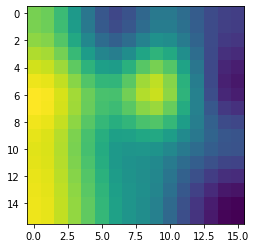

In [87]:
# Upscale the image, Train, Get the shape, Form my dense layer

#Upscale the (4,4) part of the 3, 4, 4 image to 16, 16, 16,
import cv2

up_size = 16
n_images = len(pd_x)
tac_image = np.zeros((n_images, 3, up_size, up_size), np.float32) 
for row in range(n_images):

    #resize image to 3, up_size, up_size
    for channel in range(3):
        image_per_channel = pd_image[row][channel]
        tac_image[row][channel] = cv2.resize(image_per_channel.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)

# Show scaled image
plt.imshow(pd_image[0][1])
plt.show()


In [88]:
#convert to tensor values
device = torch.device("cpu")
tac_image = torch.from_numpy(tac_image.astype(np.float32)).to(device)
tac_label = torch.from_numpy(tac_label.astype(np.float32)).to(device)


In [89]:
#split the data into train and test
tac_image_train, tac_image_test, tac_label_train, tac_label_test = train_test_split(tac_image, tac_label, test_size=0.1, shuffle=True)

#split into train and validation
tac_image_train, tac_image_valid, tac_label_train, tac_label_valid = train_test_split(tac_image_train, tac_label_train, test_size=0.3, shuffle = True)


In [ ]:
#Batch training for the data

class Batch_Taxels(Dataset):

    def __init__(self, tac_image_train, tac_label_train, tac_image_valid, tac_label_valid, valid = None):
        self.x = tac_image_train
        self.y = tac_label_train
        self.xvalid = tac_image_valid
        self.yvalid = tac_label_valid
        self.valid = valid

    def __len__(self):
        if self.valid == True:
            return self.xvalid.shape[0]
        return self.x.shape[0]

    def __getitem__(self, idx):

        if self.valid == True:
            return self.xvalid[idx], self.yvalid[idx]
        return self.x[idx], self.y[idx]

#Divide the data into batches
dataset = Batch_Taxels(tac_image_train, tac_label_train, tac_image_valid, tac_label_valid)
dataset2 = Batch_Taxels(tac_image_train, tac_label_train, tac_image_valid, tac_label_valid, valid = True)

xelaloader = DataLoader(dataset = dataset, batch_size=32, shuffle=True)
xelaloadervalid = DataLoader(dataset = dataset2, batch_size=32, shuffle=True)

In [90]:
class CNN(nn.Module):

    def __init__(self, in_channels=3, num_classes=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.shape[0], -1)
        #print(x.shape) 
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) #apply droupout in the layer
        x = torch.sigmoid(self.fc3(x))
        return x

       
       
model = CNN().to('cpu')
model.load_state_dict(torch.load('cnn_model_15_05_25.pth'))

<All keys matched successfully>

In [100]:
y_test = tac_label_valid
model.eval()  # set model to evaluation mode
with torch.no_grad():  # disable gradient computation
    y_pred = model(tac_image_valid)
    y_pred = np.round(y_pred)


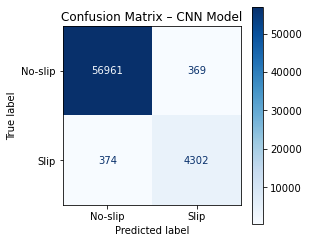

In [ ]:

cm = confusion_matrix(y_test, y_pred)

class_names = ["No-slip", "Slip"]  # 0 → No-slip, 1 → Slip

# 3. Display with labels and title
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 4. Plot 
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix – CNN Model")
plt.show()

In [33]:
from pytorch_grad_cam import GradCAM 
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image 

In [34]:
model.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [64]:
from random import randint
gradcam_images=[]

for _ in range(16):
    img = randint(1, 700)
    input_tensor = tac_image[img].unsqueeze(0).to(device)  # Add batch dimension
    target_layers = [model.conv2]
    cam = GradCAM(model=model, target_layers=target_layers)
    target = None
    grayscale_cam = cam(input_tensor=input_tensor, targets=target,)
    gradcam_images.append(grayscale_cam)

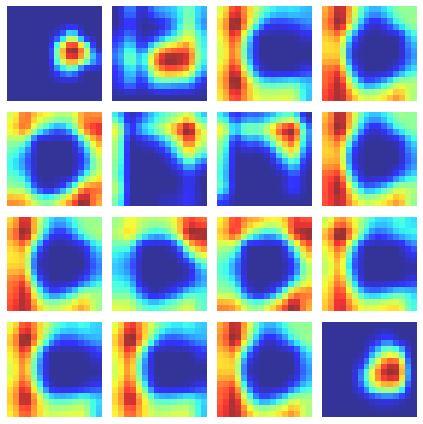

In [65]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for idx, ax in enumerate(axes.flatten()):
    cam = gradcam_images[idx].squeeze()
    ax.imshow(cam, cmap='jet', alpha=0.8)
    ax.axis('off')

plt.tight_layout()
plt.show()
